In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy as pt
from sklearn import preprocessing, linear_model, model_selection, metrics, datasets
import itertools as itertools

6. In this exercise, you will further analyze the Wage data set considered throughout this chapter.

In [137]:
# clean up wages csv exported from .rda file
wages_df = pd.read_csv('wage.csv')
wages_df = wages_df.drop(wages_df.columns[0], axis = 1)
wages_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


(a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

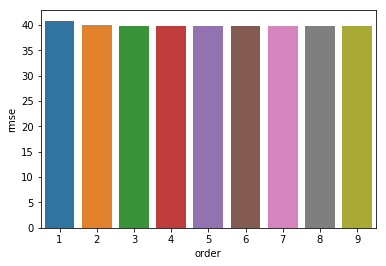

In [75]:
cv_result = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(wages_df):
    train, test = wages_df.iloc[train_idx], wages_df.iloc[test_idx]
    rmses = []
    for i in range(1, 10):
        p = preprocessing.PolynomialFeatures(i)
        train_X = p.fit_transform(pd.DataFrame(train.age))
        model = linear_model.LinearRegression(fit_intercept=False).fit(train_X, train.wage)
        test_X = p.fit_transform(pd.DataFrame(test.age))
        preds = model.predict(test_X)
        rmse = np.sqrt(metrics.mean_squared_error(test.wage, preds))
        rmses.append(rmse)
    cv_result = cv_result.append(pd.Series(rmses), ignore_index=True)
    
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'order' : cv_result.columns + 1})
sns.barplot(y='rmse', x='order', data=bar_df)

In [91]:
sorted_cv_result = cv_result.mean().sort_values()
order = sorted_cv_result.index[0] + 1
rmse = sorted_cv_result[0] + 1
print('Best polynomial from CV: \n order: {} \n rmse: {}'.format(order, rmse))

Best polynomial from CV: 
 order: 4 
 rmse: 41.84406227564555


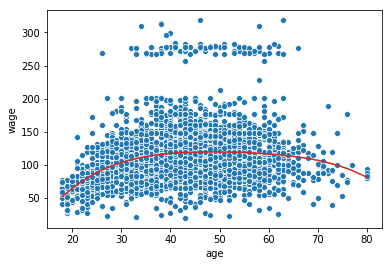

In [93]:
p = preprocessing.PolynomialFeatures(4)
X = p.fit_transform(pd.DataFrame(wages_df.age))
model = linear_model.LinearRegression(fit_intercept=False).fit(X, wages_df.wage)

sns.scatterplot(x=wages_df.age, y=wages_df.wage)
sns.lineplot(x=wages_df.age,y=model.predict(X), color='tab:red')

In [111]:
def fit_statsmodels_gls(order):
    p = preprocessing.PolynomialFeatures(order)
    X = p.fit_transform(pd.DataFrame(wages_df.age))
    return sm.GLS(wages_df.wage, X).fit()
    
models = [fit_statsmodels_gls(i) for i in range(1, 10)]
sm.stats.anova_lm(*models,typ=1)

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.706045,2.239014e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.896534,1.672143e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.812810,5.095509e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805609,3.694938e-01
5,2993.0,4.766389e+06,1.0,3932.257506,2.469946,1.161476e-01
6,2993.0,4.764599e+06,-0.0,1790.516286,-inf,NaN
7,2993.0,4.764136e+06,-0.0,462.429471,-inf,NaN
8,2993.0,4.764981e+06,-0.0,-844.193749,inf,NaN


(b) Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

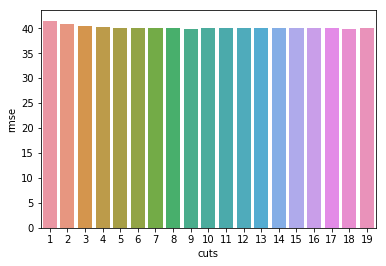

In [129]:
cv_result = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(wages_df):
    train, test = wages_df.iloc[train_idx], wages_df.iloc[test_idx]
    rmses = []
    for i in range(1, 20):
        num_bins = i + 1
        train_X = pd.get_dummies(pd.cut(train['age'], i + 1))
        model = linear_model.LinearRegression().fit(train_X, train.wage)
        test_X = pd.get_dummies(pd.cut(test['age'], i + 1))
        preds = model.predict(test_X)
        rmse = np.sqrt(metrics.mean_squared_error(test.wage, preds))
        rmses.append(rmse)
    cv_result = cv_result.append(pd.Series(rmses), ignore_index=True)
    
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'cuts' : cv_result.columns + 1})
sns.barplot(y='rmse', x='cuts', data=bar_df)

In [131]:
sorted_cv_result = cv_result.mean().sort_values()
cuts = sorted_cv_result.index[0] + 1
rmse = sorted_cv_result[0]
print('Best number of cuts from CV: \n order: {} \n rmse: {}'.format(cuts, rmse))

Best number of cuts from CV: 
 order: 9 
 rmse: 42.50687660099233


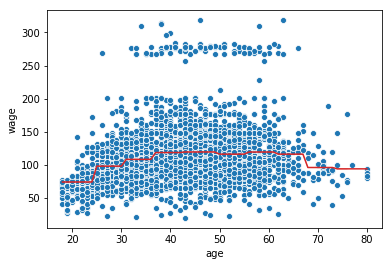

In [133]:
num_cuts = 9
X = pd.get_dummies(pd.cut(wages_df['age'], num_cuts + 1))
model = linear_model.LinearRegression().fit(X, wages_df.wage)
sns.scatterplot(x=wages_df.age, y=wages_df.wage)
sns.lineplot(x=wages_df.age,y=model.predict(X), color='tab:red')

7. The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

In [139]:
wages_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


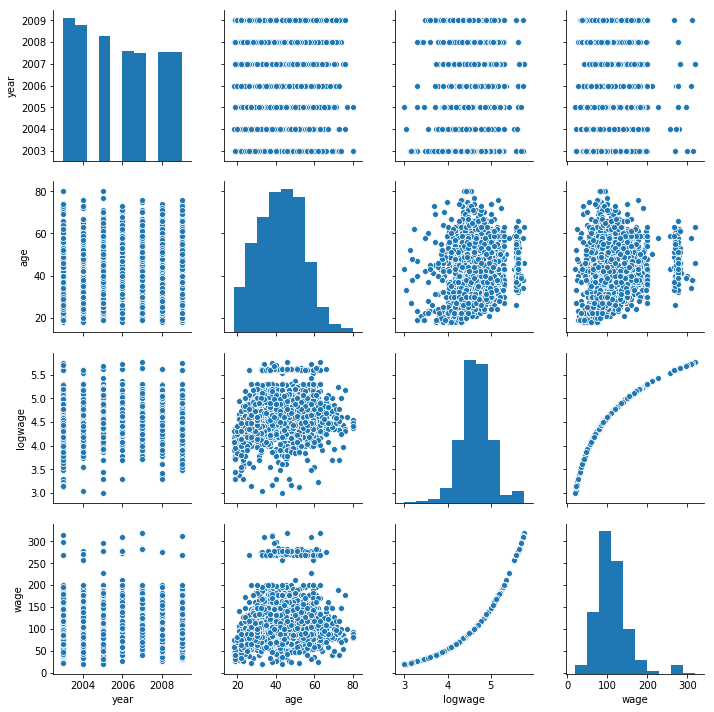

In [141]:
sns.pairplot(wages_df)

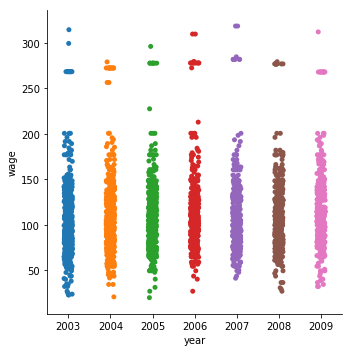

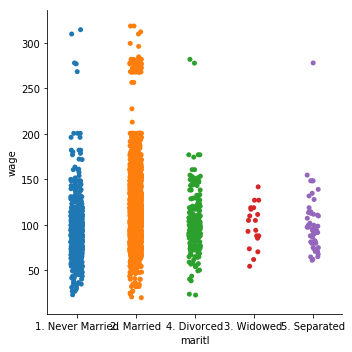

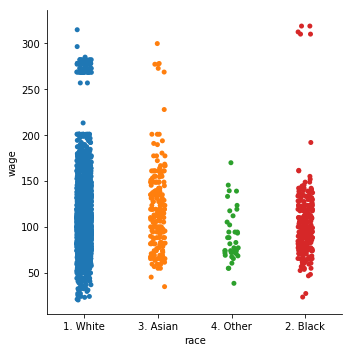

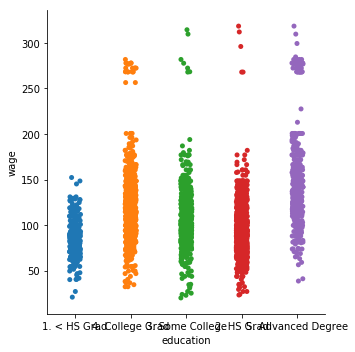

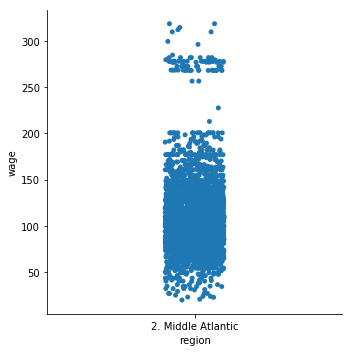

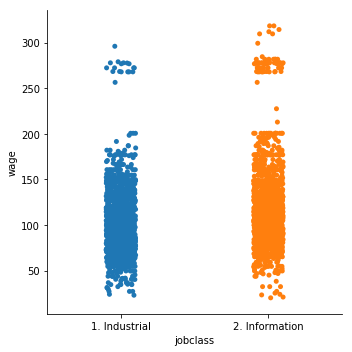

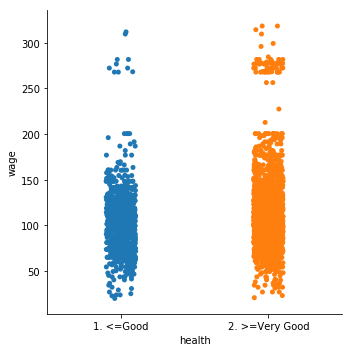

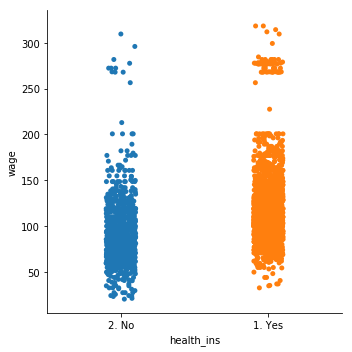

In [162]:
# The predictors are all categorical, catplot them
predictors = wages_df.drop(['age','logwage', 'wage'],axis=1).columns
for idx, fx in enumerate(predictors):
    sns.catplot(x=fx, y='wage', data=wages_df)

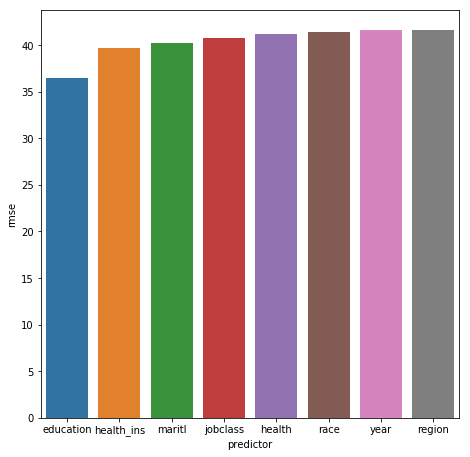

In [225]:
# Get CV rmse for linear regression onto each one-hot encoded predictor
cv_result = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=8).split(wages_df):
    train, test = wages_df.iloc[train_idx], wages_df.iloc[test_idx]
    rmses = []
    for predictor in predictors:
        train_X = pd.get_dummies(train[predictor])
        model = linear_model.LinearRegression().fit(train_X, train.wage)
        test_X = pd.get_dummies(test[predictor])
        preds = model.predict(test_X)
        rmse = np.sqrt(metrics.mean_squared_error(test.wage, preds))
        rmses.append(rmse)
    cv_result = cv_result.append(pd.Series(rmses, index=predictors), ignore_index=True)
    
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'predictor' : cv_result.columns }).sort_values('rmse')
_, _ = plt.subplots(figsize=(7.5,7.5))
sns.barplot(y='rmse', x='predictor', data=bar_df)

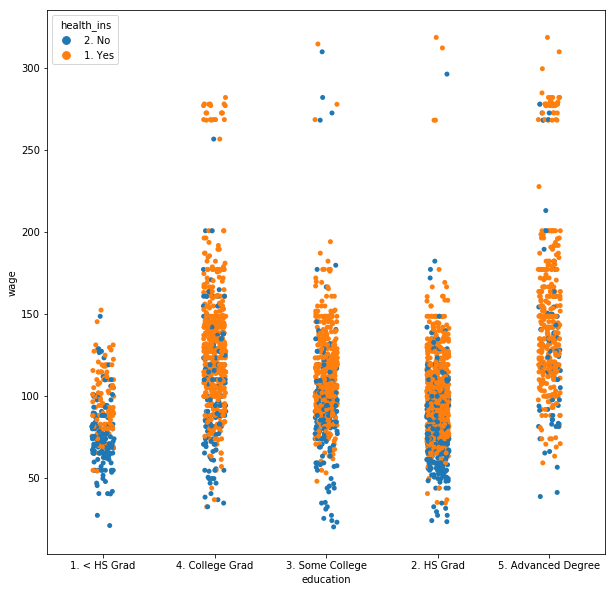

In [241]:
_, _ = plt.subplots(figsize=(10,10))
sns.stripplot(x='education', y='wage',hue='health_ins', data=wages_df)

In [233]:
sorted_cv_result = cv_result.mean().sort_values()
order = sorted_cv_result.index[0]
rmse = sorted_cv_result[0]
print('Best predictor from CV: \n predictor: {} \n rmse: {}'.format(order, rmse))

Best predictor from CV: 
 predictor: education 
 rmse: 36.493249491738155


In [243]:
# hmm.. with all categorical predictors what benefit is fitting a non-linear model?
# - TODO: think about what it means to have non-linear functions of one-hot columns..
# - values in a column are binary: what benefit does a non-linear function of 1 or zero
#   bring compared a linear function?
# - ?feature engineer to get new columns with non linear relationships with the
#   dependent variable?

8. Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [255]:
auto_df = pd.read_csv('auto.csv')
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


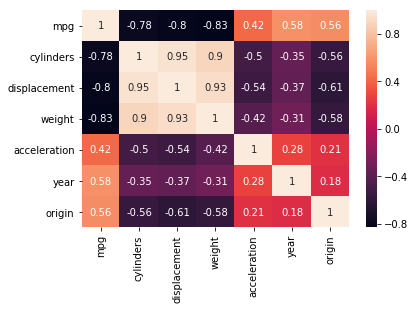

In [258]:
sns.heatmap(auto_df.corr(), annot=True)

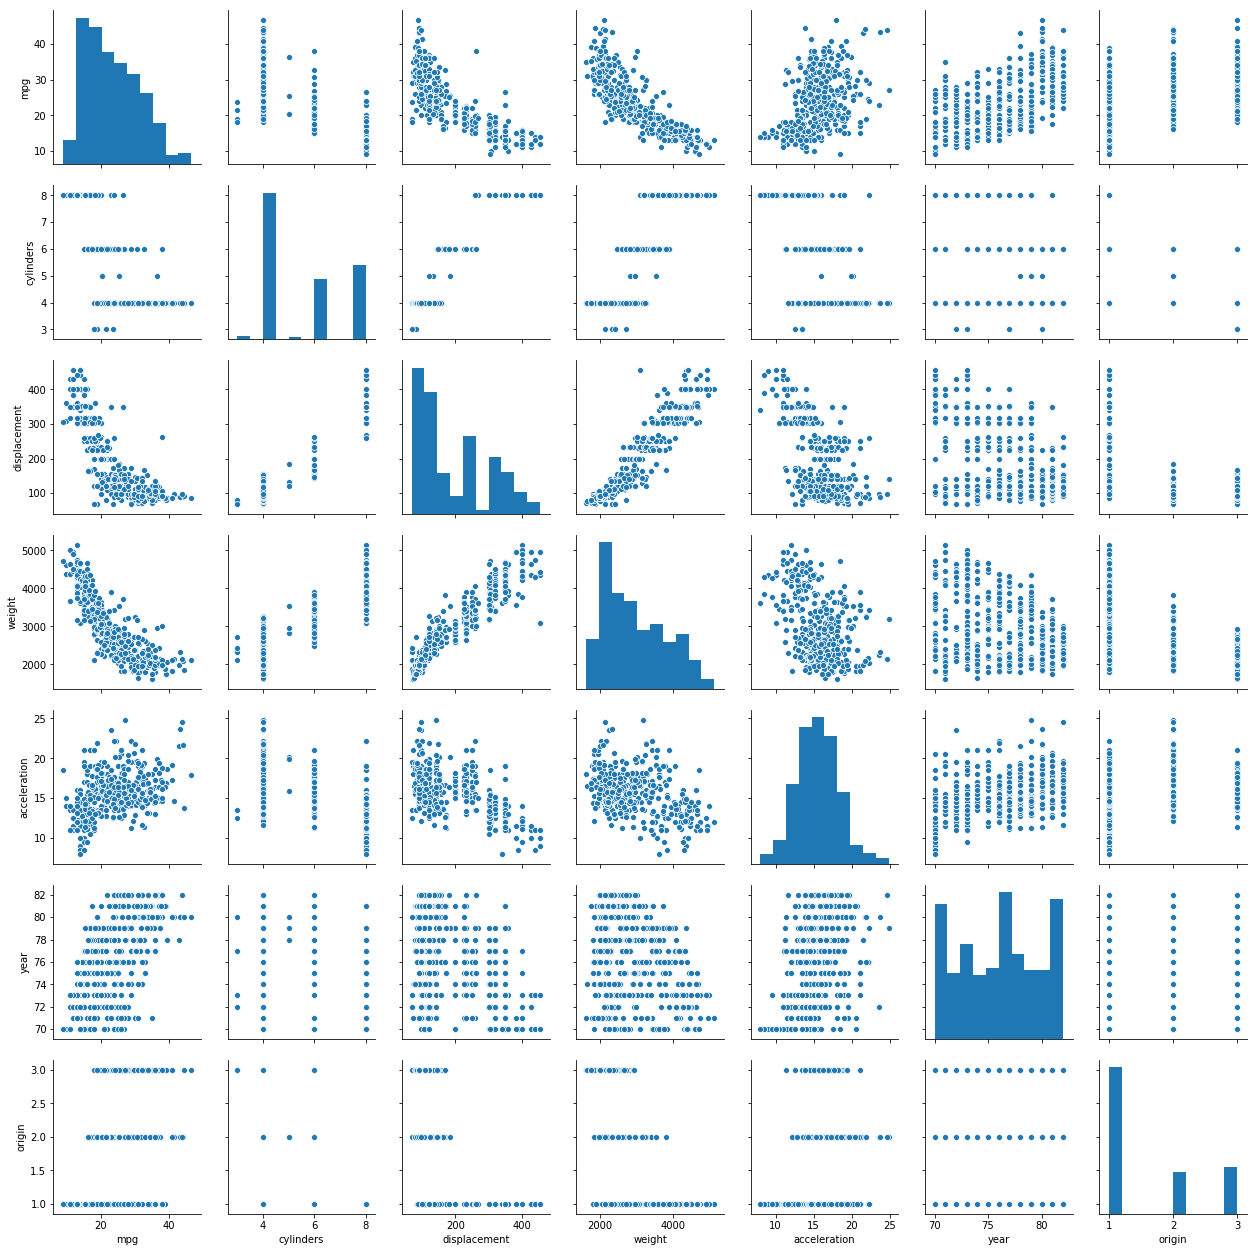

In [256]:
sns.pairplot(auto_df)

In [364]:
# See the lab for this chapter, where I originally wrote these fns to polyfill functionality
# available out the box in R.

def gen_coeff_covar_matrix(true, preds, d_matrix):
    '''calculate covariance matrix for regression coefficients'''
    mse = metrics.mean_squared_error(true, preds)
    return mse * np.linalg.inv(d_matrix.T @ d_matrix)
    
def gen_pointwise_se_curves(cov_matrix, preds, d_matrix):
    '''calculate pointwise standard error: see last paragraph and footnote on p267 ISL'''
    var_f_hat = np.diagonal((d_matrix @ cov) @ d_matrix.T)
    return pd.DataFrame({'error_pos' : preds + 2 * np.sqrt(var_f_hat), \
                         'error_neg' : preds - 2 * np.sqrt(var_f_hat)})

In [453]:
def run_cv(df, n_splits, extract_x, extract_y, fit_model, rnge):
    cv_result = pd.DataFrame()
    for train_idx, test_idx in model_selection.KFold(n_splits=n_splits).split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        rmses = []
        for i in rnge:
            # train
            train_X = extract_x(train, i)
            train_y = extract_y(train)
            model = fit_model(train_X, train_y)
            # test
            test_X =  extract_x(test, i)
            test_y = extract_y(test)
            preds = model.predict(test_X)
            rmse = np.sqrt(metrics.mean_squared_error(test_y, preds))
            rmses.append(rmse)
        cv_result = cv_result.append(pd.Series(rmses), ignore_index=True)
    return cv_result

Best from CV:
 64.20975196037901


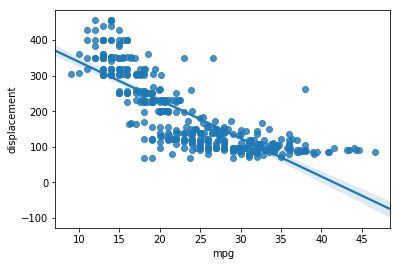

In [441]:
# Explore the non-linear relationship between displacement and mpg (1)
# Benchmark against linear regression

cv_result = run_cv(auto_df,
                   10,
                   lambda df, i: pd.DataFrame(df.mpg),
                   lambda df: df.displacement,
                   lambda x, y: linear_model.LinearRegression().fit(x, y),
                   range(1,2))

print('Best from CV:\n {}'.format(cv_result.mean()[0]))
sns.regplot(x='mpg', y='displacement', data=auto_df)

Best from CV: 
 order: 8 
 rmse: 47.738303158163255


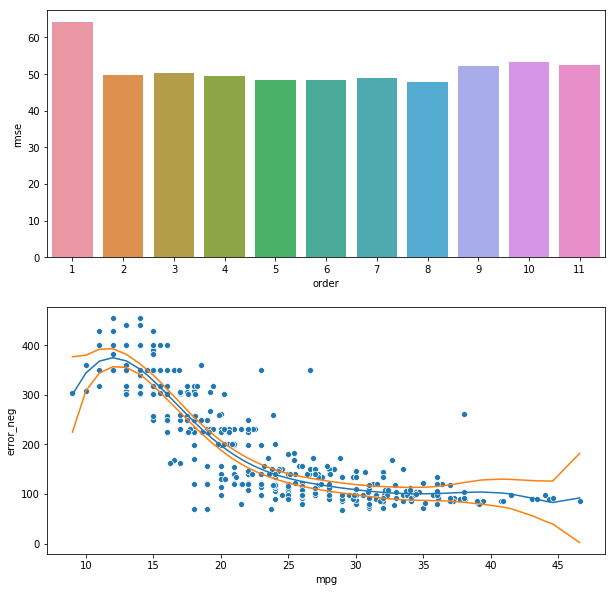

In [442]:
# Explore the non-linear relationship between displacement and mpg (2)
# Polynomial Regression

cv_result = run_cv(auto_df,
                   10,
                   lambda df, i: preprocessing.PolynomialFeatures(i).fit_transform(pd.DataFrame(df.mpg)),
                   lambda x: x.displacement,
                   lambda x,y: linear_model.LinearRegression(fit_intercept=False).fit(x, y),
                   range(1,12))

# bump the index so loc corresponds to order
cv_result.columns = cv_result.columns + 1

# print the best order and score
sorted_cv_result = cv_result.mean().sort_values()
order = sorted_cv_result.index[0]
rmse = sorted_cv_result.iloc[0]
print('Best from CV: \n order: {} \n rmse: {}'.format(order, rmse))

# fit best polynomial from CV to all the data
x = extract_x_mpg_polynomial(auto_df, 8)
model = linear_model.LinearRegression(fit_intercept=False).fit(x, auto_df.displacement)
preds = model.predict(x)

# plots
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# plot polynomial rmses
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'order' : cv_result.columns})
sns.barplot(y='rmse', x='order', data=bar_df, ax=ax1)

# plot best polynomial
sns.scatterplot(x='mpg', y='displacement', data=auto_df, ax=ax2)
sns.lineplot(x=auto_df.mpg, y=preds, ax=ax2)

# plot standard error curves
cov = gen_coeff_covar_matrix(auto_df.displacement, preds, x)
err_curves = gen_pointwise_se_curves(cov, preds, x)

sns.lineplot(x=auto_df.mpg, y=err_curves.error_pos, ax=ax2, color='tab:orange')
sns.lineplot(x=auto_df.mpg, y=err_curves.error_neg, ax=ax2, color='tab:orange')

Best from CV: 
 knots: 2 
 rmse: 66.60776079337028


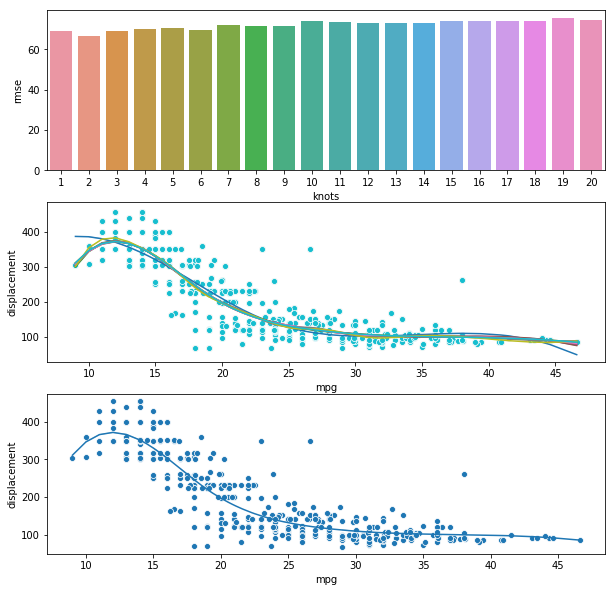

In [443]:
# Explore the non-linear relationship between displacement and mpg (3)
# Cubic Spline

def spline_basis_extract_x(df, i):
    f = 'bs(mpg, df={}, degree=3, include_intercept=True)'.format(i+4)
    return pt.dmatrix(f, df)
    

cv_result = run_cv(auto_df,
                   10,
                   spline_basis_extract_x,
                   lambda df: df.displacement,
                   lambda x, y: linear_model.LinearRegression(fit_intercept=False).fit(x, y),
                   range(1,21))

# bump the index so index loc = number of knots
cv_result.columns = cv_result.columns + 1

# print the best number of knots and score
sorted_cv_result = cv_result.mean().sort_values()
sorted_cv_result
knots = sorted_cv_result.index[0]
rmse = sorted_cv_result.iloc[0]
print('Best from CV: \n knots: {} \n rmse: {}'.format(knots, rmse))

# plots
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10))

# plot some splines
for i in range(1, 10):
    x = spline_basis_extract_x(auto_df, i)
    y = auto_df.displacement
    model = linear_model.LinearRegression(fit_intercept=False).fit(x, y)
    preds = model.predict(x)
    sns.scatterplot(x='mpg', y='displacement', data=auto_df, ax=ax2)
    sns.lineplot(x=auto_df.mpg, y=preds, ax=ax2)

# plot the best spline 
x = spline_basis_extract_x(auto_df, 2)
y = auto_df.displacement
model = linear_model.LinearRegression(fit_intercept=False).fit(x, y)
preds = model.predict(x)
sns.scatterplot(x='mpg', y='displacement', data=auto_df, ax=ax3)
sns.lineplot(x=auto_df.mpg, y=preds, ax=ax3)

# plot rmse bars
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'knots' : cv_result.columns})
sns.barplot(y='rmse', x='knots', data=bar_df, ax=ax1)

# plot best spline
sns.scatterplot(x='mpg', y='displacement', data=auto_df, ax=ax2)
sns.lineplot(x=auto_df.mpg, y=preds, ax=ax2)

Best from CV:
 89.76591479405623


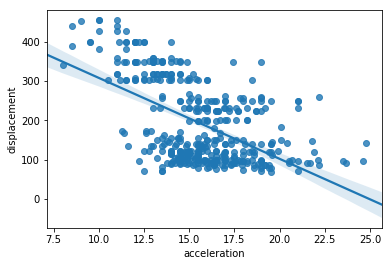

In [444]:
# Explore the relationship between acceleration and dispacement (1)
# Benchmark against linear regression

cv_result = run_cv(auto_df,
                   10,
                   lambda df, i: pd.DataFrame(df.acceleration),
                   lambda df: df.displacement,
                   lambda x, y: linear_model.LinearRegression().fit(x, y),
                   range(1,2))

print('Best from CV:\n {}'.format(cv_result.mean()[0]))
sns.regplot(x='acceleration', y='displacement', data=auto_df)

Best from CV: 
 knots: 5 
 rmse: 98.44436614610075


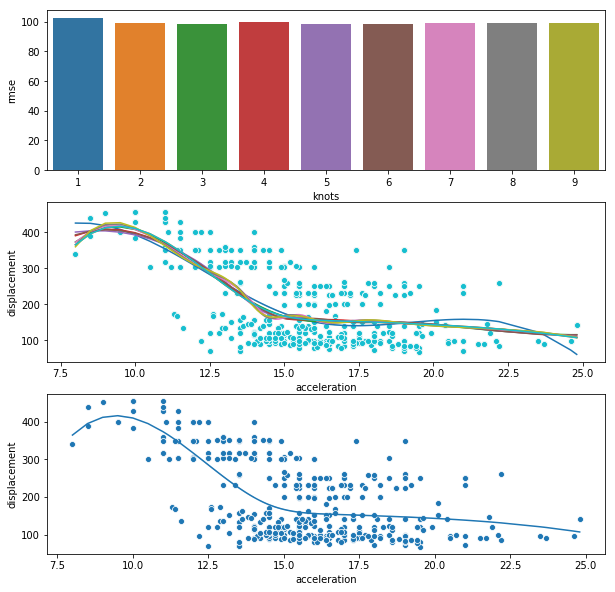

In [446]:
# Explore the non-linear relationship between displacement and acceleration (3)
# Linear Spline

def spline_basis_extract_x(df, i):
    f = 'bs(acceleration, df={}, degree=3, include_intercept=True)'.format(i + 4)
    return pt.dmatrix(f, df)
    

cv_result = run_cv(auto_df,
                   10,
                   spline_basis_extract_x,
                   lambda df: df.displacement,
                   lambda x, y: linear_model.LinearRegression(fit_intercept=False).fit(x, y),
                   range(1,10))

# bump the index so index loc = number of knots
cv_result.columns = cv_result.columns + 1

# print the best number of knots and score
sorted_cv_result = cv_result.mean().sort_values()
sorted_cv_result
knots = sorted_cv_result.index[0]
rmse = sorted_cv_result.iloc[0]
print('Best from CV: \n knots: {} \n rmse: {}'.format(knots, rmse))

# plots
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10))

# plot some splines
for i in range(1, 10):
    x = spline_basis_extract_x(auto_df, i)
    y = auto_df.displacement
    model = linear_model.LinearRegression(fit_intercept=False).fit(x, y)
    preds = model.predict(x)
    sns.scatterplot(x='acceleration', y='displacement', data=auto_df, ax=ax2)
    sns.lineplot(x=auto_df.acceleration, y=preds, ax=ax2)

# plot the best spline 
x = spline_basis_extract_x(auto_df, 2)
y = auto_df.displacement
model = linear_model.LinearRegression(fit_intercept=False).fit(x, y)
preds = model.predict(x)
sns.scatterplot(x='acceleration', y='displacement', data=auto_df, ax=ax3)
sns.lineplot(x=auto_df.acceleration, y=preds, ax=ax3)

# plot rmse bars
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'knots' : cv_result.columns})
sns.barplot(y='rmse', x='knots', data=bar_df, ax=ax1)

# plot best spline
sns.scatterplot(x='acceleration', y='displacement', data=auto_df, ax=ax2)
sns.lineplot(x=auto_df.acceleration, y=preds, ax=ax2)

9. This question uses the variables `dis` (the weighted mean of distances to five Boston employment centers) and `nox` (nitrogen oxides concentration in parts per 10 million) from the Boston data. We will treat `dis` as the predictor and `nox` as the response.

In [451]:
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']], columns= [c for c in boston_df['feature_names']] + ['Price'])
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


(a) Use the `poly()` function to fit a cubic polynomial regression to predict `nox` using `dis`. Report the regression output, and plot the resulting data and polynomial fits.

(b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

(c) Perform cross-validation or another approach to select the opti- mal degree for the polynomial, and explain your results.

Best from CV: 
 order: 3 
 rmse: 0.06115394767838496


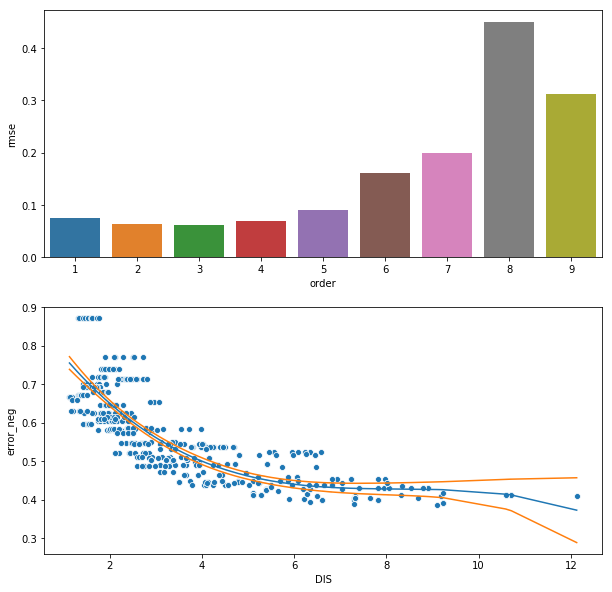

In [466]:
cv_result = run_cv(boston_df,
                   10, 
                   lambda df, i: preprocessing.PolynomialFeatures(i).fit_transform(pd.DataFrame(df.DIS)),
                   lambda df: df.NOX,
                   lambda x, y: linear_model.LinearRegression(fit_intercept=False).fit(x, y),
                   range(1,10))

# bump the index so loc corresponds to order
cv_result.columns = cv_result.columns + 1

# print the best order and score
sorted_cv_result = cv_result.mean().sort_values()
order = sorted_cv_result.index[0]
rmse = sorted_cv_result.iloc[0]
print('Best from CV: \n order: {} \n rmse: {}'.format(order, rmse))

# fit best polynomial from CV to all the data
x = preprocessing.PolynomialFeatures(order).fit_transform(pd.DataFrame(boston_df.DIS))
model = linear_model.LinearRegression(fit_intercept=False).fit(x, boston_df.NOX)
preds = model.predict(x)

# plots
_, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 10))

# plot polynomial rmses
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'order' : cv_result.columns})
sns.barplot(y='rmse', x='order', data=bar_df, ax=ax1)

# plot best polynomial
sns.scatterplot(x='DIS', y='NOX', data=boston_df, ax=ax2)
sns.lineplot(x=boston_df.DIS, y=preds, ax=ax2)

# plot standard error curves
cov = gen_coeff_covar_matrix(boston_df.NOX, preds, x)
err_curves = gen_pointwise_se_curves(cov, preds, x)

sns.lineplot(x=boston_df.DIS, y=err_curves.error_pos, ax=ax2, color='tab:orange')
sns.lineplot(x=boston_df.DIS, y=err_curves.error_neg, ax=ax2, color='tab:orange')

(d) Use the bs() function to fit a regression spline to predict nox using dis. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

(e) Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

(f) Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

Best from CV: 
 knots: 4 
 rmse: 0.1253672577242327


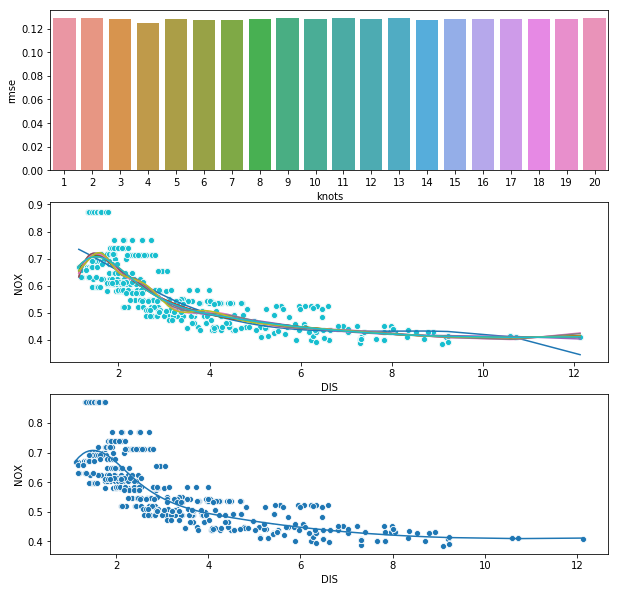

In [475]:
def spline_basis_extract_x(df, i):
    f = 'bs(DIS, df={}, degree=3, include_intercept=True)'.format(i+4)
    return pt.dmatrix(f, df)
    

cv_result = run_cv(boston_df,
                   10,
                   spline_basis_extract_x,
                   lambda df: df.NOX,
                   lambda x, y: linear_model.LinearRegression(fit_intercept=False).fit(x, y),
                   range(1,21))

# bump the index so index loc = number of knots
cv_result.columns = cv_result.columns + 1

# print the best number of knots and score
sorted_cv_result = cv_result.mean().sort_values()
sorted_cv_result
knots = sorted_cv_result.index[0]
rmse = sorted_cv_result.iloc[0]
print('Best from CV: \n knots: {} \n rmse: {}'.format(knots, rmse))

# plots
_, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 10))

# plot some splines
for i in range(1, 10):
    x = spline_basis_extract_x(boston_df, i)
    y = boston_df.NOX
    model = linear_model.LinearRegression(fit_intercept=False).fit(x, y)
    preds = model.predict(x)
    sns.scatterplot(x='DIS', y='NOX', data=boston_df, ax=ax2)
    sns.lineplot(x=boston_df.DIS, y=preds, ax=ax2)

# plot the best spline 
x = spline_basis_extract_x(boston_df, 2)
y = boston_df.NOX
model = linear_model.LinearRegression(fit_intercept=False).fit(x, y)
preds = model.predict(x)
sns.scatterplot(x='DIS', y='NOX', data=boston_df, ax=ax3)
sns.lineplot(x=boston_df.DIS, y=preds, ax=ax3)

# plot rmse bars
bar_df = pd.DataFrame({'rmse' : cv_result.mean(), 'knots' : cv_result.columns})
sns.barplot(y='rmse', x='knots', data=bar_df, ax=ax1)

# plot best spline
sns.scatterplot(x='DIS', y='NOX', data=boston_df, ax=ax2)
sns.lineplot(x=boston_df.DIS, y=preds, ax=ax2)

10. This question relates to the College data set.

In [659]:
# clean up the college csv which was exported from a .rda file
coll_df = pd.read_csv('college.csv')
coll_df = coll_df.drop(coll_df.columns[0], axis=1)
coll_df.Private = coll_df.Private.map({'Yes' : 1, 'No' : 0})
coll_df.columns = [x.translate({ord(c): None for c in '.'}) for x in coll_df.columns]
coll_df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,FUndergrad,PUndergrad,Outstate,RoomBoard,Books,Personal,PhD,Terminal,SFRatio,percalumni,Expend,GradRate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


(a) Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

(b) Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

(c) Evaluate the model obtained on the test set, and explain the results obtained.

(d) For which variables, if any, is there evidence of a non-linear relationship with the response?

...hmmm, whilst we can select the best model for each number `p` of predictors, we cannot select between models with different numbers `p` of predictors without using the test set, cross validation or a woeful metric like adjusted R squared. I assume from wording they want the latter as the question specifically says 'on the training set'.

- I could do CV on the training set, even though it seems a bit odd to split into a train and test set then do cross validation with the training set - especially given already small dataset.

- I could do everything inside the KV fold: For every model in the forward subset selection, fit the GAM and evaluate result with test error.. but that would be quite alot of models?

In [725]:
target = 'Outstate'
predictors = coll_df.columns.drop(target)
cv_result = pd.DataFrame()
for train_idx, test_idx in model_selection.KFold(n_splits=10).split(coll_df):
    train, test = coll_df.iloc[train_idx], coll_df.iloc[test_idx]
    stepwise_predictors = []
    stepwise_rmses = []
    while len(stepwise_predictors) < len(predictors):
        remaining_predictors = predictors.drop(stepwise_predictors)
        lowest_rmse = np.finfo('d').max
        best_p = None
        for p in remaining_predictors:
            ps = stepwise_predictors + [p]
            train_x = train[ps]
            train_y = train[target]
            model = linear_model.LinearRegression().fit(train_x, train_y)
            test_x = test[ps]
            test_y = test[target]
            preds = model.predict(test_x)
            rmse = np.sqrt(metrics.mean_squared_error(test[target], preds))
            if rmse < lowest_rmse:
                lowest_rmse = rmse
                best_p = p
        stepwise_predictors.append(best_p)
        stepwise_rmses.append(lowest_rmse)
    cv_result = cv_result.append(pd.Series(stepwise_rmses), ignore_index=True)

Best from CV: 
 predictors: 10 
 rmse: 1864.77390764911


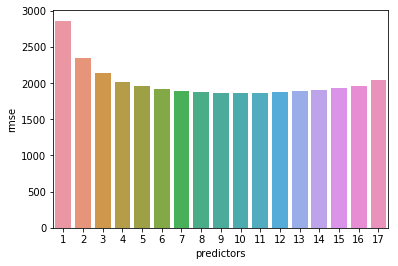

In [726]:
means = cv_result.mean()
means.index = means.index + 1

# print the best number of predictors and score
sorted_cv_result = means.sort_values()
predictors = sorted_cv_result.index[0]
rmse = sorted_cv_result.iloc[0]
print('Best from CV: \n predictors: {} \n rmse: {}'.format(predictors, rmse))

bar_df = pd.DataFrame({'predictors' : means.index, 'rmse': means})
sns.barplot(x='predictors', y='rmse', data=bar_df)

In [730]:
# How big is the search space for forward stepwise with a few basis functions?

def n_choose_k(n, k):
    return np.math.factorial(n) / (np.math.factorial(n - k) * np.math.factorial(k))

def search_space_size(k, p, b):
    fwd_selection_space_wo_basis = p * ((1 + p) / 2)
    fwd_selection_space_wi_basis = sum([n_choose_k(p, min(b, p)) for p in range(1, p + 1)])
    return k * (fwd_selection_space_wo_basis + fwd_selection_space_wi_basis)
    
# number of folds in CV
k = 10 
# number of predictors
p = len(coll_df.columns) - 1
# number of basis functions of predictors
b = 2

search_space_size(k, p, b)

9700.0

In [728]:
# TODO: Return to this
# - What's the best way to contrain the search for non-linear models?
# - .. try adding a search over splines / polys in the forward stepwise?
# - .. looking at graphs and guessing..?

11. In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.
Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient esti- mate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued un- til convergence—that is, until the coefficient estimates stop changing.
We now try this out on a toy example.

(a) Generate a response `Y` and two predictors `X1` and `X2`, with `n = 100`.

(b) Initialize βˆ1 to take on a value of your choice. It does not matter what value you choose.

(c) Keeping βˆ1 fixed, fit the model:

    `Y − βˆ 1 X 1 = β 0 + β 2 X 2 + ε .`
    
You can do this as follows:

```
  a=y-beta1*x1
  beta2=lm(a∼x2)$coef[2]
```

(d) Keeping βˆ2 fixed, fit the model

`Y − βˆ 2 X 2 = β 0 + β 1 X 1 + ε .`

You can do this as follows:

```
 a=y-beta2*x2
 beta1=lm(a∼x1)$coef[2]
```

(e) Write a for loop to repeat (c) and (d) 1,000 times. Report the estimates of βˆ0, βˆ1, and βˆ2 at each iteration of the for loop. Create a plot in which each of these values is displayed, with βˆ0, βˆ1, and βˆ2 each shown in a different color.

(f) Compare your answer in (e) to the results of simply performing multiple linear regression to predict Y using X1 and X2. Use the abline() function to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

(g) On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple re- gression coefficient estimates?


.. All answered in question 12

12. This problem is a continuation of the previous exercise. In a toy example with p = 100, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting procedure. How many backfitting iterations are required in order to obtain a “good” approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [20]:
predictor_df = pd.DataFrame(np.random.normal(1,10, size=(100, 10)))
predictor_df[0] = np.repeat(1, 100)

# make y a linear combination of the predictors, so we can see the coefficients end up @ the 
# correct solution. Spread out the solution for a pretty plot.

solution = pd.DataFrame(np.arange(1, predictor_df.shape[1] + 1))

y_df = predictor_df @ solution #pd.DataFrame((predictor_df[1] * 5) + (predictor_df[2] * -2) + 11)

# doesn't matter where the coefficients start, kick them off at 0
coeff_df = pd.DataFrame(np.repeat(0, predictor_df.shape[1])).T


history = pd.DataFrame()
i = 0
while i < 10:
    for p in predictor_df:
        # fit p, keeping the rest constant
        constant_preds = predictor_df.drop([p], axis=1)
        constant_coeffs = coeff_df.T.drop([p], axis=0)
        a = y_df - (constant_preds @ constant_coeffs)
        m = linear_model.LinearRegression(fit_intercept=False).fit(pd.DataFrame(predictor_df[p]), a)
        coeff_df[p] = m.coef_[0][0]
        intercept = m.intercept_
        history = history.append(coeff_df, ignore_index=True)
    
    i += 1

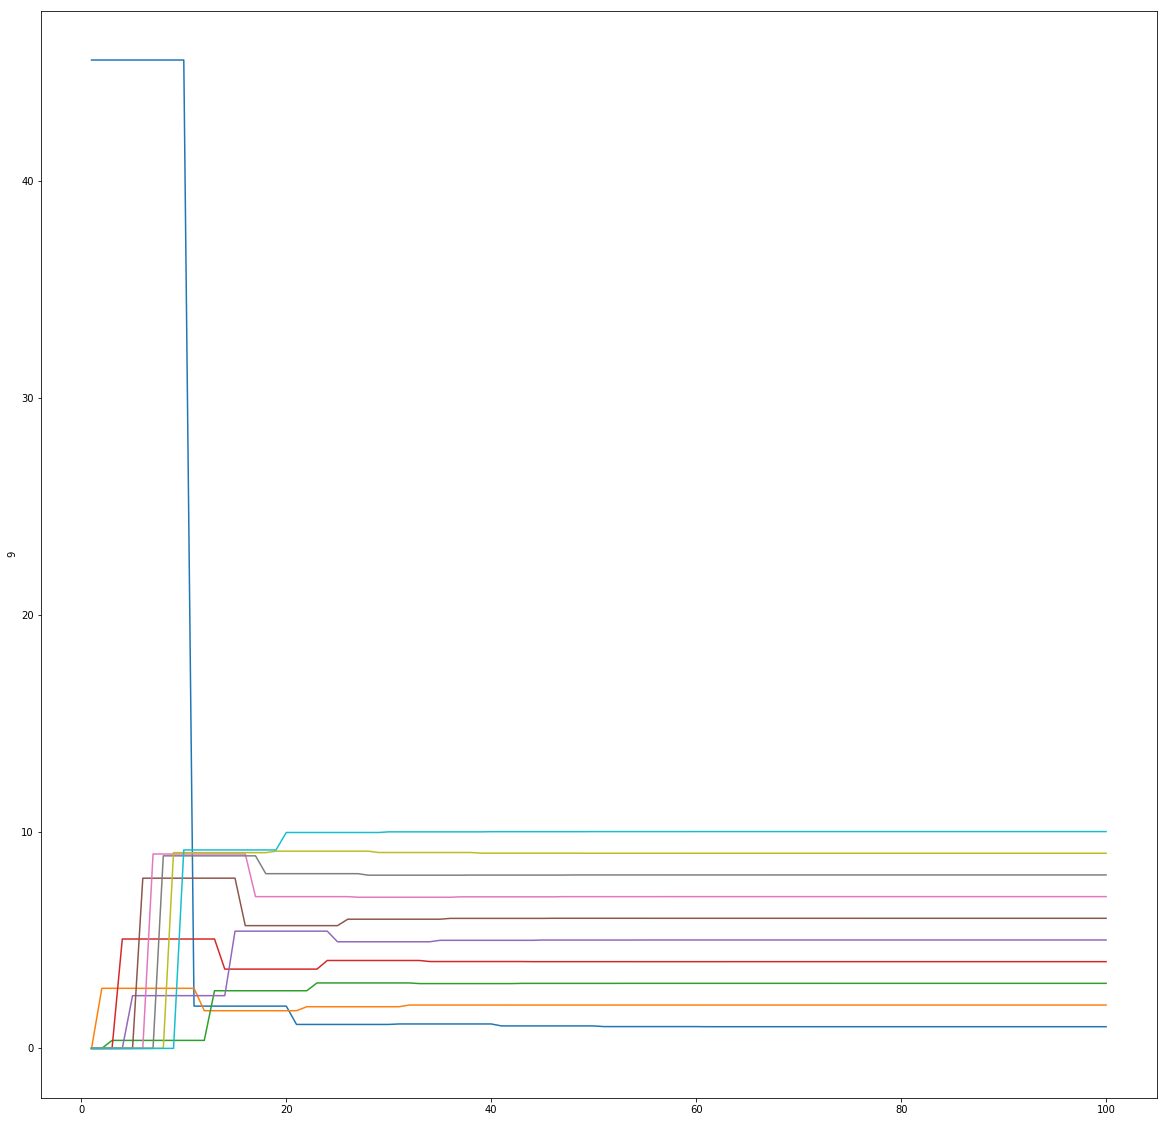

In [21]:
plt.subplots(figsize=(20,20))
for p in predictor_df.columns:
    sns.lineplot(x = history.index + 1, y = history[p])